## 准备工作

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [2]:
%pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Note: you may need to restart the kernel to use updated packages.


## 1. 生成 Embedding (基于 text-embedding-ada-002 模型)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](images/embedding-vectors.svg)

### 新闻联播(Chinese official daily news)

Source:[新闻联播数据集](https://www.kaggle.com/datasets/noxmoon/chinese-official-daily-news-since-2016)

![dataset](images/chinese_news.png)


新闻联播是中央电视台制作的每日新闻节目。 它在所有中国大陆地方电视台同时播出，使其成为世界上收视率最高的节目之一。 它自 1 月 1 日 1978 年开始播出。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [3]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken
# 从 openai.embeddings_utils 包中导入 get_embedding 函数。
# 这个函数可以获取 GPT-3 模型生成的嵌入向量。
# 嵌入向量是模型内部用于表示输入数据的一种形式。
from openai.embeddings_utils import get_embedding

#### 加载数据集

In [22]:
input_datapath = "data/chinese_news.csv"
df = pd.read_csv(input_datapath)
df.head(2)

,date,tag,headline,content
0,2016-01-01,详细全文,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...
1,2016-01-01,详细全文,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...


In [23]:
df = df[["date", "tag", "headline", "content"]]
df = df.dropna()

df.head(2)

,date,tag,headline,content
0,2016-01-01,详细全文,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...
1,2016-01-01,详细全文,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...


In [16]:
len(df["content"][0])

1441

#### Embedding 模型关键参数

In [17]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [24]:
# 设置要筛选的评论数量为1000
top_n = 100
# 选取前200条评论
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.head(top_n * 2) 
# 丢弃"date"列，因为我们在这个分析中不再需要它。
df.drop("date", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.content.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（100）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)

# 打印出剩余评论的数量。
len(df)

100

#### 生成 Embeddings 并保存（非必须步骤，可直接复用项目中文件）

In [25]:
# 实际生成会耗时几分钟
# 提醒：非必须步骤，可直接复用项目中的嵌入文件 chinese_news_with_embeddings_100
df["embedding"] = df.content.apply(lambda x: get_embedding(x, engine=embedding_model))

output_datapath = "data/chinese_news_with_embeddings_100.csv"

df.to_csv(output_datapath)

## 2.读取 chinese_news_with_embeddings_100 嵌入文件

In [51]:
embedding_datapath = "data/chinese_news_with_embeddings_100.csv"

df_embedded = pd.read_csv(embedding_datapath)

#### 查看 Embedding 结果

In [52]:
df_embedded["embedding"][0]

'[-0.015515187755227089, 0.004187786020338535, 0.000739190261811018, -0.02247072570025921, -0.0097824577242136, 0.008092880249023438, -0.02673082798719406, 0.00963125005364418, -0.020919207483530045, -0.005315267015248537, 0.01825006864964962, 0.013155038468539715, -0.009355132468044758, -0.015699267387390137, -0.035132698714733124, 0.009854773990809917, 0.016264650970697403, -0.03757831081748009, 0.020629940554499626, -0.021537184715270996, 0.017303379252552986, 0.004273251164704561, -0.01825006864964962, 0.005837918259203434, -0.007448605261743069, 0.004776179790496826, 0.012339834123849869, -0.017724130302667618, 0.011386570520699024, 0.00534156383946538, 0.013792739249765873, 0.006797756068408489, 0.0020577346440404654, -0.00963125005364418, 0.004861644934862852, -0.003589530708268285, -0.0120965875685215, -0.041391365230083466, 0.0010683127911761403, -0.021918490529060364, 0.013312820345163345, 0.01642243191599846, 0.0030044240411370993, -0.009151331149041653, 0.003025790443643927

In [53]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [54]:
len(df_embedded["embedding_vec"][0])

1536

In [55]:
df_embedded.head(2)

,Unnamed: 0,tag,headline,content,n_tokens,embedding,embedding_vec
0,101,国内,安理会强烈谴责朝鲜进行核试验,联合国安理会成员6号举行紧急磋商后发表媒体声明，强烈谴责朝鲜当天进行核试验。\n声明说，...,269,"[-0.015515187755227089, 0.004187786020338535, ...","[-0.015515187755227089, 0.004187786020338535, ..."
1,102,国内,伊朗指责沙特空袭伊驻也门使馆,据伊朗媒体报道，伊朗外交部发言人安萨里今天表示，沙特空袭了伊朗驻也门萨那的使馆，造成人员受...,142,"[-0.01878906972706318, -0.0016094655729830265,...","[-0.01878906972706318, -0.0016094655729830265,..."


## 3. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [56]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [57]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [58]:
len(df_embedded["embedding_vec"])

100

In [59]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [60]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [65]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

/Users/hanzhenfeng/anaconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [66]:
df_embedded['Cluster']

0     1
1     1
2     1
3     0
4     3
     ..
95    0
96    0
97    1
98    1
99    1
Name: Cluster, Length: 100, dtype: int32

In [69]:
df_embedded.head(10)

,Unnamed: 0,tag,headline,content,n_tokens,embedding,embedding_vec,Cluster
0,101,国内,安理会强烈谴责朝鲜进行核试验,联合国安理会成员6号举行紧急磋商后发表媒体声明，强烈谴责朝鲜当天进行核试验。\n声明说，...,269,"[-0.015515187755227089, 0.004187786020338535, ...","[-0.015515187755227089, 0.004187786020338535, ...",1
1,102,国内,伊朗指责沙特空袭伊驻也门使馆,据伊朗媒体报道，伊朗外交部发言人安萨里今天表示，沙特空袭了伊朗驻也门萨那的使馆，造成人员受...,142,"[-0.01878906972706318, -0.0016094655729830265,...","[-0.01878906972706318, -0.0016094655729830265,...",1
2,103,国际,科隆跨年夜性侵案确认3名嫌疑人,德国科隆在迎接2016年的跨年夜活动中，有近百名女性遭到众多男子的袭击、抢劫，甚至有人被强奸...,223,"[-0.010458508506417274, -0.022253869101405144,...","[-0.010458508506417274, -0.022253869101405144,...",1
3,104,国际,亚太主要股市全线下挫,受多重利空因素影响，亚太主要股市今天全线下挫。其中日本东京股市低开低走，日经股指大跌2.33...,148,"[-0.033686473965644836, -0.022628054022789, 0....","[-0.033686473965644836, -0.022628054022789, 0....",0
4,105,详细全文,中共中央国务院隆重举行国家科学技术奖励大会,中共中央、国务院8号上午在北京隆重举行国家科学技术奖励大会。党和国家领导人习近平、李克强、...,2268,"[0.0026452827733010054, 0.007268833927810192, ...","[0.0026452827733010054, 0.007268833927810192, ...",3
5,106,详细全文,【2015年度国家科学技术奖励大会】创新引领产业发展 服务国家战略,在本届评选中，由于参评国家最高科技奖的人员均没有通过评审，时隔十一年之后，最高科技奖再次出现...,438,"[-0.0008483855053782463, -0.001071779523044824...","[-0.0008483855053782463, -0.001071779523044824...",0
6,107,详细全文,全国统战部长会议在京召开 俞正声出席会议并讲话,全国统战部长会议今天在北京召开，中共中央政治局常委、全国政协主席俞正声出席并讲话，强调统一战...,1037,"[-0.0160109531134367, -0.00269283982925117, 0....","[-0.0160109531134367, -0.00269283982925117, 0....",3
7,108,详细全文,重庆：建设创新开放的内陆发展高地,习近平总书记在重庆视察时的殷切希望和寄语，在广大重庆干部群众中引起强烈共鸣，大家备受鼓舞。\...,332,"[-0.008491403423249722, -0.009281612932682037,...","[-0.008491403423249722, -0.009281612932682037,...",3
8,109,详细全文,【治国理政新实践】坚持自主创新 弯道超车引领科技发展,"习近平指出,自力更生是中华民族自立于世界民族之林的奋斗基点,自主创新是我们攀登世界科技高峰的...",1544,"[-0.023440159857273102, 0.005167308729141951, ...","[-0.023440159857273102, 0.005167308729141951, ...",2
9,110,详细全文,创新派驻监督体制 党内监督不留空白,日前，经党中央同意，中共中央办公厅印发了《关于全面落实中央纪委向中央一级党和国家机关派驻纪检...,990,"[0.009811037220060825, 0.012587745673954487, -...","[0.009811037220060825, 0.012587745673954487, -...",3


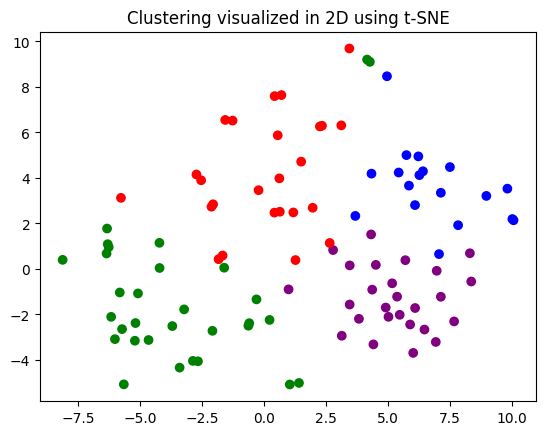

In [68]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类：比原来的数据集打的标签要准确一点。**

## 4. 使用 Embedding 进行文本搜索

![cosine](images/cosine.png)

In [70]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
from openai.embeddings_utils import get_embedding, cosine_similarity

In [71]:
type(df_embedded["embedding_vec"][0])

list

In [85]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, content, n=3, pprint=True):
    product_embedding = get_embedding(
        content,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .content
    )
    if pprint:
        for r in results:
            print(r)
            print()
    return results

In [86]:
# 使用 '关于爱国主义教育' 作为新闻检索描述 3 作为数量，
# 调用 search_reviews 函数来查找最相似的前3条内容。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, '关于爱国主义教育', n=3)

国务院总理李克强6日下午在中南海紫光阁会见美国哥伦比亚大学校长、法学教授布林格。
李克强积极评价中美教育合作，以及哥伦比亚大学同中方在法学等诸多领域开展的学术交流与人才培养，表示中方愿同包括哥伦比亚大学在内的各国高校、学术、研究等机构加强联系与合作，通过“互联网+”等战略集众智、汇众力，为中国经济社会持续发展培养更多高层次、国际化人才，更好实现互利共赢。
布林格表示，哥伦比亚大学重视对华合作，愿同中方积极探讨推进“互联网+教育”等方式的合作，帮助中国培养高层次人才，助力中国经济社会发展。同时愿为增进西方对华了解、共同应对全球性问题作出努力。


为应对日益严重的暴力恐怖袭击威胁，美国政府8号宣布推出一系列新举措，包括成立一个特别工作组和一个全球接触中心，以动员国内和国外力量打击暴力极端主义。
由于极端组织利用网络招募海外人员并散布煽动性言论，美国越来越担心本土一些受极端主义思想蛊惑的激进人员发动“独狼式”袭击。


新华社今天在“治国理政新实践”专栏播发《激扬正气定乾坤——以习近平同志为总书记的党中央带头加强作风建设述评》。
述评指出，“八项规定”“反对四风”“群众路线”“三严三实”……作为建设的着力点，就是党心民心的契合点。党的十八大以来，以习近平同志为总书记的党中央始终把党风廉政建设紧紧抓在手上，言必信、行必果，以身作则、率先垂范，点准穴位、猛药去疴，标本兼治、弛而不息，党风政风为之一振、社情民风为之一新。人民群众对干部清正、政府清廉、政治清明的殷切期盼正在逐步变为现实。
今年，我们将迎来中国共产党成立95周年。近一个世纪的不懈奋斗，铸就了中国共产党自我革新、与时俱进的实践品格。我们坚信，在以习近平同志为总书记的党中央坚强领导下，全党上下团结一心，一定能把我们的党建设好，为实现中华民族伟大复兴的中国梦领航开路。




In [87]:
df_embedded['Cluster']

0     1
1     1
2     1
3     0
4     3
     ..
95    0
96    0
97    1
98    1
99    1
Name: Cluster, Length: 100, dtype: int32

In [90]:
df_embedded['content'][0]

'\u3000\u3000联合国安理会成员6号举行紧急磋商后发表媒体声明，强烈谴责朝鲜当天进行核试验。\n声明说，安理会成员强烈谴责本次核试验，核试验明显违反安理会第1718、第1874、第2087和第2094号决议，挑战不扩散机制，因此对国际和平与安全的明显威胁继续存在。声明说，安理会将立即着手起草对朝鲜采取进一步行动的新决议。\n朝鲜政府6号宣布进行了核试验。这是朝鲜自2006年以来进行的第四次核试验。联合国安理会从2006年以来，已经三次通过决议对朝方予以谴责，并对朝鲜实施制裁措施。\n'

In [91]:
res = search_reviews(df_embedded, df_embedded['content'][0], n=3)

　　联合国安理会成员6号举行紧急磋商后发表媒体声明，强烈谴责朝鲜当天进行核试验。
声明说，安理会成员强烈谴责本次核试验，核试验明显违反安理会第1718、第1874、第2087和第2094号决议，挑战不扩散机制，因此对国际和平与安全的明显威胁继续存在。声明说，安理会将立即着手起草对朝鲜采取进一步行动的新决议。
朝鲜政府6号宣布进行了核试验。这是朝鲜自2006年以来进行的第四次核试验。联合国安理会从2006年以来，已经三次通过决议对朝方予以谴责，并对朝鲜实施制裁措施。


6号朝鲜宣布在丰溪里核试验场成功进行了氢弹试验，我国环保部第一时间启动辐射环境应急监测。在东北三省及山东沿海地区布设环境辐射自动监测站37个，同时在重点区域和人口密集区域使用了14台移动监测车，做到全覆盖监测。截至目前，共获得监测数据52000多个，放射性监测结果未发现异常。


当地时间8号中午，韩国在韩朝军事分界线一带全面重启对朝扩音喊话。韩国军方表示，重启扩音喊话是针对朝鲜核试验的惩罚行动。目前，韩朝边境安装扩音喊话设备的地区已进入最高戒备状态，部署了搭载有红外探测器的无人侦察机、迫击炮定位雷达等武器装备。当天晚些时候，朝鲜也启动了对韩扩音喊话。
去年8月，韩朝举行高级别对话，韩方确认在没有异常事态发生的前提下，停止全部对朝扩音喊话。




In [92]:
res = search_reviews(df_embedded, 'dog food', n=3)

国家食品药品监管总局今天发布，2015年前三季度，全国共查处食品药品违法案件24.6万件，吊销许可证238件，捣毁制假售假窝点744个。互联网已成为食品药品违法犯罪的主要渠道。


中国有句俗话，民以食为天，在物质丰富的当今，很多人对这句话不一定有很深切的体会。然而对小麦育种专家王辉来说，从当年吃饱饭的朴素愿望，到五十年始终如一的执着努力，土地和粮食已经成为他生命中最厚重的情结。
冬闲时节，农民都很少下地，王辉却照样忙碌，采集数据，分析苗情，从庄户孩子到农学教授，70多年里他从没离开过土地。上世纪60年代，饿过肚子，吃过树叶玉米芯充饥的王辉，报考了西北农学院，他当时最大的愿望就是让父老乡亲吃饱饭。
最初搞育种，两亩试验田全靠自己种，当小学教师的爱人和四个女儿在课余都成了她的义务工。小女儿还记得，有一次爸爸答应带她去买过年的新衣服，走到半路却要回地里去。
这都是王辉地里的娃，成百上千的原始麦种，一代一代优选组合，一个周期至少十年八年，最后也不一定能成功。在这个记录本上，一个红叉号就代表着一代组合被淘汰。王辉曾经连续五年里所有试验全部失败，有一年几乎颗粒无收。
靠着锲而不舍的坚持，王辉在育种生涯接近第三个十年的时候迎来了丰收，多个新品种接连培育成功，特别是西农979目前成为全国第四大小麦主栽品种，推广近1500万亩。在陕西岐山县，很多农民都是王教授的老朋友，他的新品种既丰产又优质，平均一亩地至少增收一百多元。
中国品牌
不论是作为轨道交通装备制造业领军企业的中国中车，还是全国主要云服务商的浪潮集团，两家企业积极开拓海外市场，正成为享誉全球的中国品牌。
最近，由浪潮集团研发的36台高端服务器成功销售到美国西雅图微软总部，用于下一代操作系统和云产品的研发与测试。这是国产品牌服务器第一次进入美国本土。
目前国内的阿里巴巴、百度、腾讯等互联网企业使用的新型整机柜服务器70%以上都是浪潮的产品。
过去一年，浪潮贡献了全球服务器市场增量的35.6%。截至目前，浪潮服务器已经占据了我国互联网市场份额的60%，总量位居全球前五。
中国中车的品牌也在走向世界。不久前在南非约翰内斯堡举办的中非装备制造业展上，非盟正式派出代表与中国中车公司洽谈铁路合作。
目前，中国中车的产品已经销售到非洲近30个国家，合作项目包括内燃机车、电力机车、内燃动车组，以及各种铁路货车客车。
在其他市场上，中国中车

In [93]:
res = search_reviews(df_embedded, 'awful', n=5)

为应对日益严重的暴力恐怖袭击威胁，美国政府8号宣布推出一系列新举措，包括成立一个特别工作组和一个全球接触中心，以动员国内和国外力量打击暴力极端主义。
由于极端组织利用网络招募海外人员并散布煽动性言论，美国越来越担心本土一些受极端主义思想蛊惑的激进人员发动“独狼式”袭击。


“无国界医生”组织的负责人10号说，该机构位于也门北部萨达省的一所医院当天遭炮弹袭击，造成至少五人死亡、多人受伤。联合国秘书长潘基文10号晚发表声明谴责医院遭袭事件，并呼吁也门冲突各方立即停火。


土耳其最大城市伊斯坦布尔著名旅游景区苏丹艾哈迈德广场12号发生爆炸，目前已造成包括袭击者在内的11人死亡，15人受伤，土耳其总理达武特奥卢证实，遇难者均为外国人，其中大部分是德国游客，目前没有中国公民伤亡的消息。土耳其已确认袭击者是极端组织成员。


7号，一名袭击者驾驶一辆油罐车闯入利比亚西部城市兹利坦的一处警察训练中心，并引爆炸弹，造成至少65人死亡，上百人受伤。目前尚无组织宣称实施了此次袭击。有安全部门人士分析，袭击很可能是极端组织在利比亚的分支策划的。自2011年利比亚战争结束以来，利比亚政局一直不稳，多地安全形势堪忧，不少恐怖和极端组织趁机在利比亚境内扩大势力范围。


德国科隆在迎接2016年的跨年夜活动中，有近百名女性遭到众多男子的袭击、抢劫，甚至有人被强奸。6号科隆警方称，已确认了三名嫌疑人的身份。根据目击者证词等线索，这起案件的罪犯大部分是“有着阿拉伯或北非面孔的男性”，年龄在18到35岁之间，直接和间接参与者可能有上千人。德国右翼团体借此再次抨击德国接纳难民的政策。德国内政部长表示，案件仍在调查中，不应随意将此事件与难民相联系。


